In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from skimage.measure import regionprops, block_reduce, regionprops_table
import tifffile
from tqdm import tqdm
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap
import hdbscan
import sklearn.cluster as cluster
import seaborn as sns
import random
import cv2

datapath = Path.cwd().parent / "data"

In [3]:
rawpath = datapath / "interim/confocal/histone_test.tif"
trackpath = datapath / "interim/confocal/histone_test_tracked.tif"

raw = tifffile.imread(rawpath)
tracked = tifffile.imread(trackpath)
savepath = Path(r'D:\OneDrive - Princeton University\GeneralExam\figures')

In [4]:
from src.utils import get_nucleus_df

nucleus_df = get_nucleus_df(raw, tracked)

129it [00:20,  6.32it/s]
100%|██████████| 46472/46472 [00:19<00:00, 2396.58it/s]


In [38]:
from src.models.fourier_transform_2d import parametrize_nuclei_from_image, single_image_transform, inverse_fourier_transform_2d
from src import utils

In [6]:
def green_image(img, track, frame):
    green = np.dstack((np.zeros_like(img), img, np.zeros_like(img)))
    print(green.shape)
    (savepath / f"{track}").mkdir(exist_ok=True)
    plt.imsave(savepath / f"{track}" / f"{frame}.png", green)
    

In [7]:
rad = 25
h = 2*rad + 1
nucleus_df = utils.get_normed_intensity_image(nucleus_df, raw, rad=rad)

46472it [00:11, 3948.34it/s]


In [85]:
k = 115
for frame, img in enumerate(nucleus_df[nucleus_df['track'] == k]["img"]):
    img = img.reshape(h, h)
    green_image(img, k, frame)

(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51, 51, 3)
(51,

In [1]:
all_fourier, all_inv_fourier = [], []

for t, frame in tqdm(enumerate(tracked)):
    fourier, inv_fourier = parametrize_nuclei_from_image(tracked[t], level=5)
    all_fourier.extend(fourier)
    all_inv_fourier.extend(inv_fourier)

nucleus_df["fourier"] = all_fourier
nucleus_df["inv_fourier"] = all_inv_fourier

NameError: name 'tqdm' is not defined

In [ ]:
all_fourier_sep = np.array([list(np.real(arr)) + list(np.imag(arr)) for arr in all_fourier])
nucleus_df["fourier"] = [f for f in all_fourier_sep]

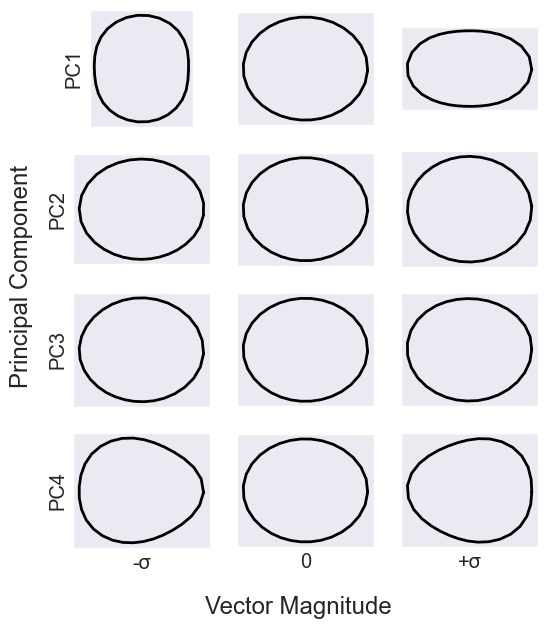

In [150]:


from sklearn.decomposition import PCA

pca = PCA(n_components=4)
pca.fit_transform(all_fourier_sep[np.abs(all_fourier_sep).sum(axis=1) < 100])

components = pca.components_
means = pca.mean_

def plot_inv_shape(ax, arr, level=5):
    arr_complex = arr[:len(arr)//2] + 1j*arr[len(arr)//2:]
    inv = inverse_fourier_transform_2d(arr_complex, level=level)
    ax.plot(np.real(inv[:, 0]), np.real(inv[:, 1]), label="average", c="k", linewidth=2)
    #set aspect to equal
    ax.set_aspect('equal')
    ax.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

sns.set_context("paper", font_scale=1.5)
sns.set_style("dark")

nrows, ncols = 4, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(6, 7))
for i, (axrow, component) in enumerate(zip(axes, components)):
    rat = np.sqrt(pca.explained_variance_[i])
    for ax, mult in zip(axrow, [-2*rat, 0, 2*rat]):
        plot_inv_shape(ax, means + mult*component)


flatax = axes.flatten()
for i in range(nrows):
    flatax[i*ncols].set_ylabel(f"PC{i+1}")
    
flatax[-3].set_xlabel("-σ")
flatax[-2].set_xlabel("0")
flatax[-1].set_xlabel("+σ")

fig.supxlabel("Vector Magnitude")
fig.supylabel("Principal Component")

plt.savefig(savepath / "PCs.png", dpi=1200)




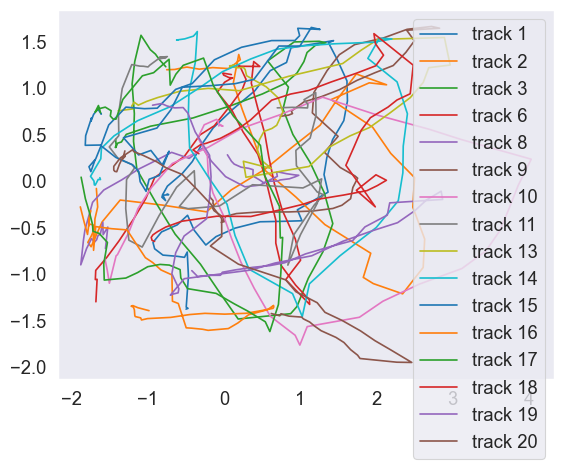

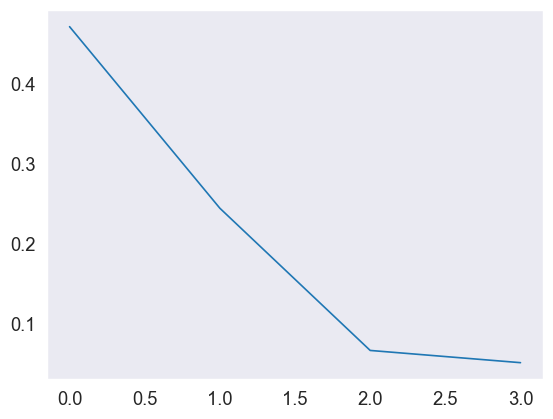

In [170]:
def rolling_mean(arr, window=5):
    return np.array([arr[max(0, i-window):min(len(arr), i+window)].mean(axis=0) for i in range(len(arr))])
def rolling_median(arr, window=5):
    return np.array([np.median(arr[max(0, i-window):min(len(arr), i+window)], axis=0) for i in range(len(arr))])

ks = [1, 2, 3, 6, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20]
series_ks = {}
imgs_ks = {}
params_ks = {}
for k in ks:
    series_ks[k] = [np.array(params) for params in nucleus_df[nucleus_df['track'] == k]["fourier"]]
    imgs_ks[k] = [np.array(img).reshape(h,h) for img in nucleus_df[nucleus_df['track'] == k]["img"]]
    params_ks[k] = pca.transform(series_ks[k])

a, b = 12, 60
func = rolling_mean
plt.figure()
for k in ks:  
    plt.plot(func(params_ks[k][a:b, 0]), func(params_ks[k][a:b, 1]), label=f"track {k}")
plt.legend()
plt.show()
plt.plot(pca.explained_variance_ratio_)
plt.show()

1 2
1 6
1 9
1 18
3 14


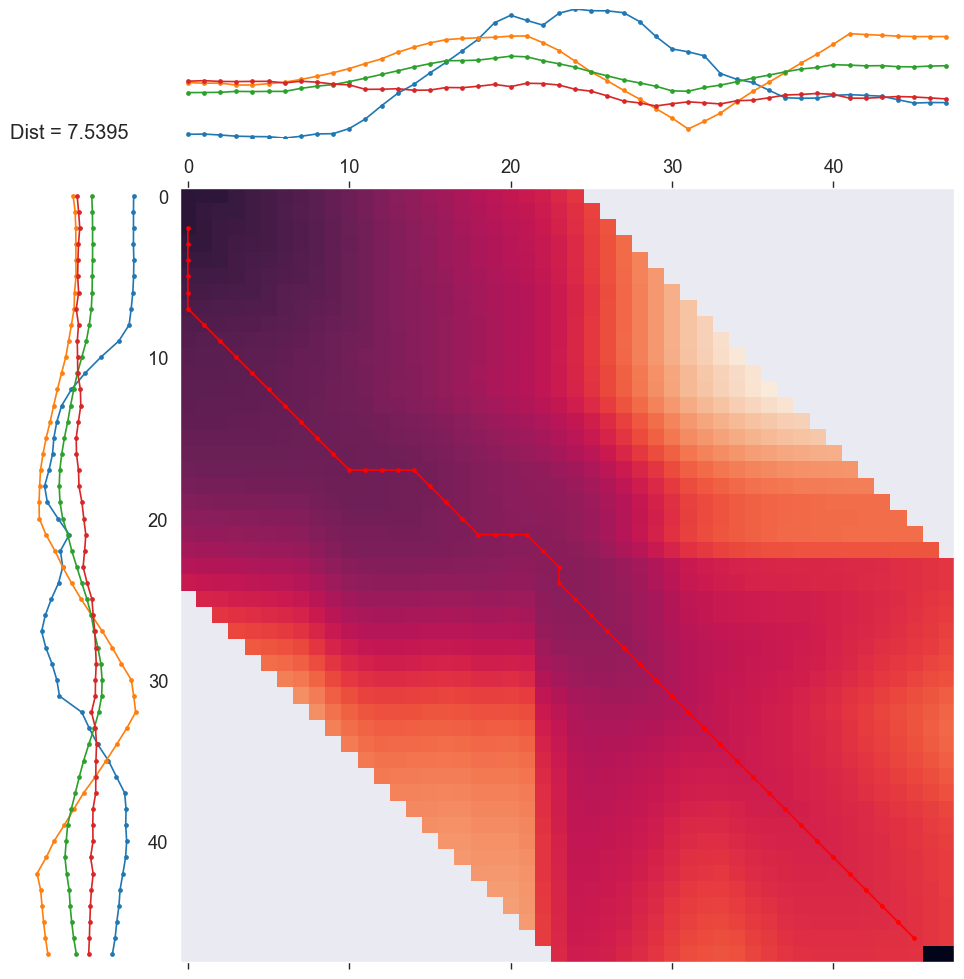

<Axes: >

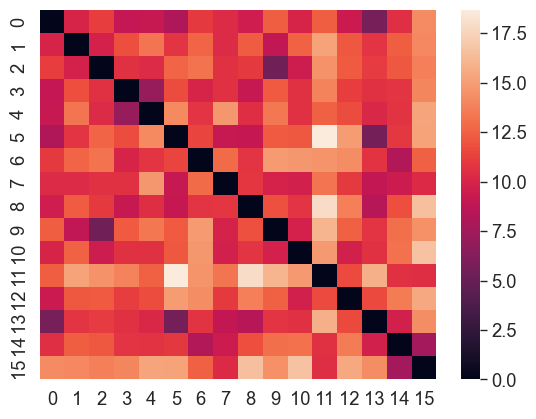

In [173]:
from sklearn.metrics import pairwise_distances
# sns.heatmap(pairwise_distances(params1[:, 3:4], params2[:, 3:4]))

from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import random
import numpy as np

distances = np.zeros((len(ks), len(ks)))

running_min = np.inf

for i, k1 in enumerate(ks):
    for j, k2 in enumerate(ks):
        if k1 == k2:
            continue
        s1, s2 = func(params_ks[k1][a:b]), func(params_ks[k2][a:b])
        d, paths = dtw.warping_paths(s1, s2, window=25, psi=2)
        distances[i, j] = d
        
        if d < running_min:
            print(k1, k2)
            running_min = d
            best_path = paths
            imgs1 = imgs_ks[k1][a:b]
            imgs2 = imgs_ks[k2][a:b]
            best_s1, best_s2 = s1, s2
            best_k1, best_k2 = k1, k2
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(best_s1, best_s2, paths, best_path)
plt.savefig(savepath / "dtw.png", dpi=1200)
plt.show()
sns.heatmap(distances)

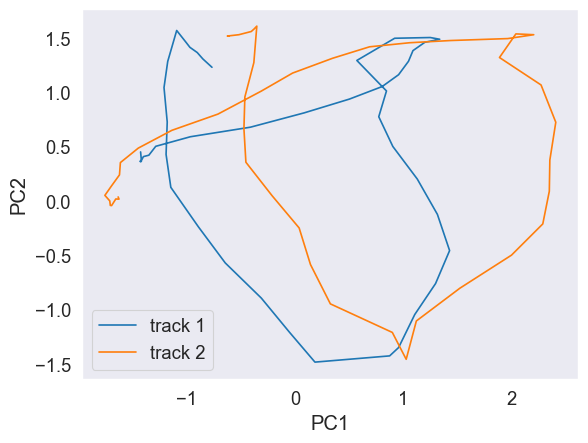

In [177]:
plt.figure()
for i, k in enumerate((best_k1, best_k2)):  
    plt.plot(func(params_ks[k][a:b, 0]), func(params_ks[k][a:b, 1]), label=f"track {i + 1}")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.savefig(savepath / "dtw_tracks.png", dpi=1200)
plt.show()

IndexError: list index out of range

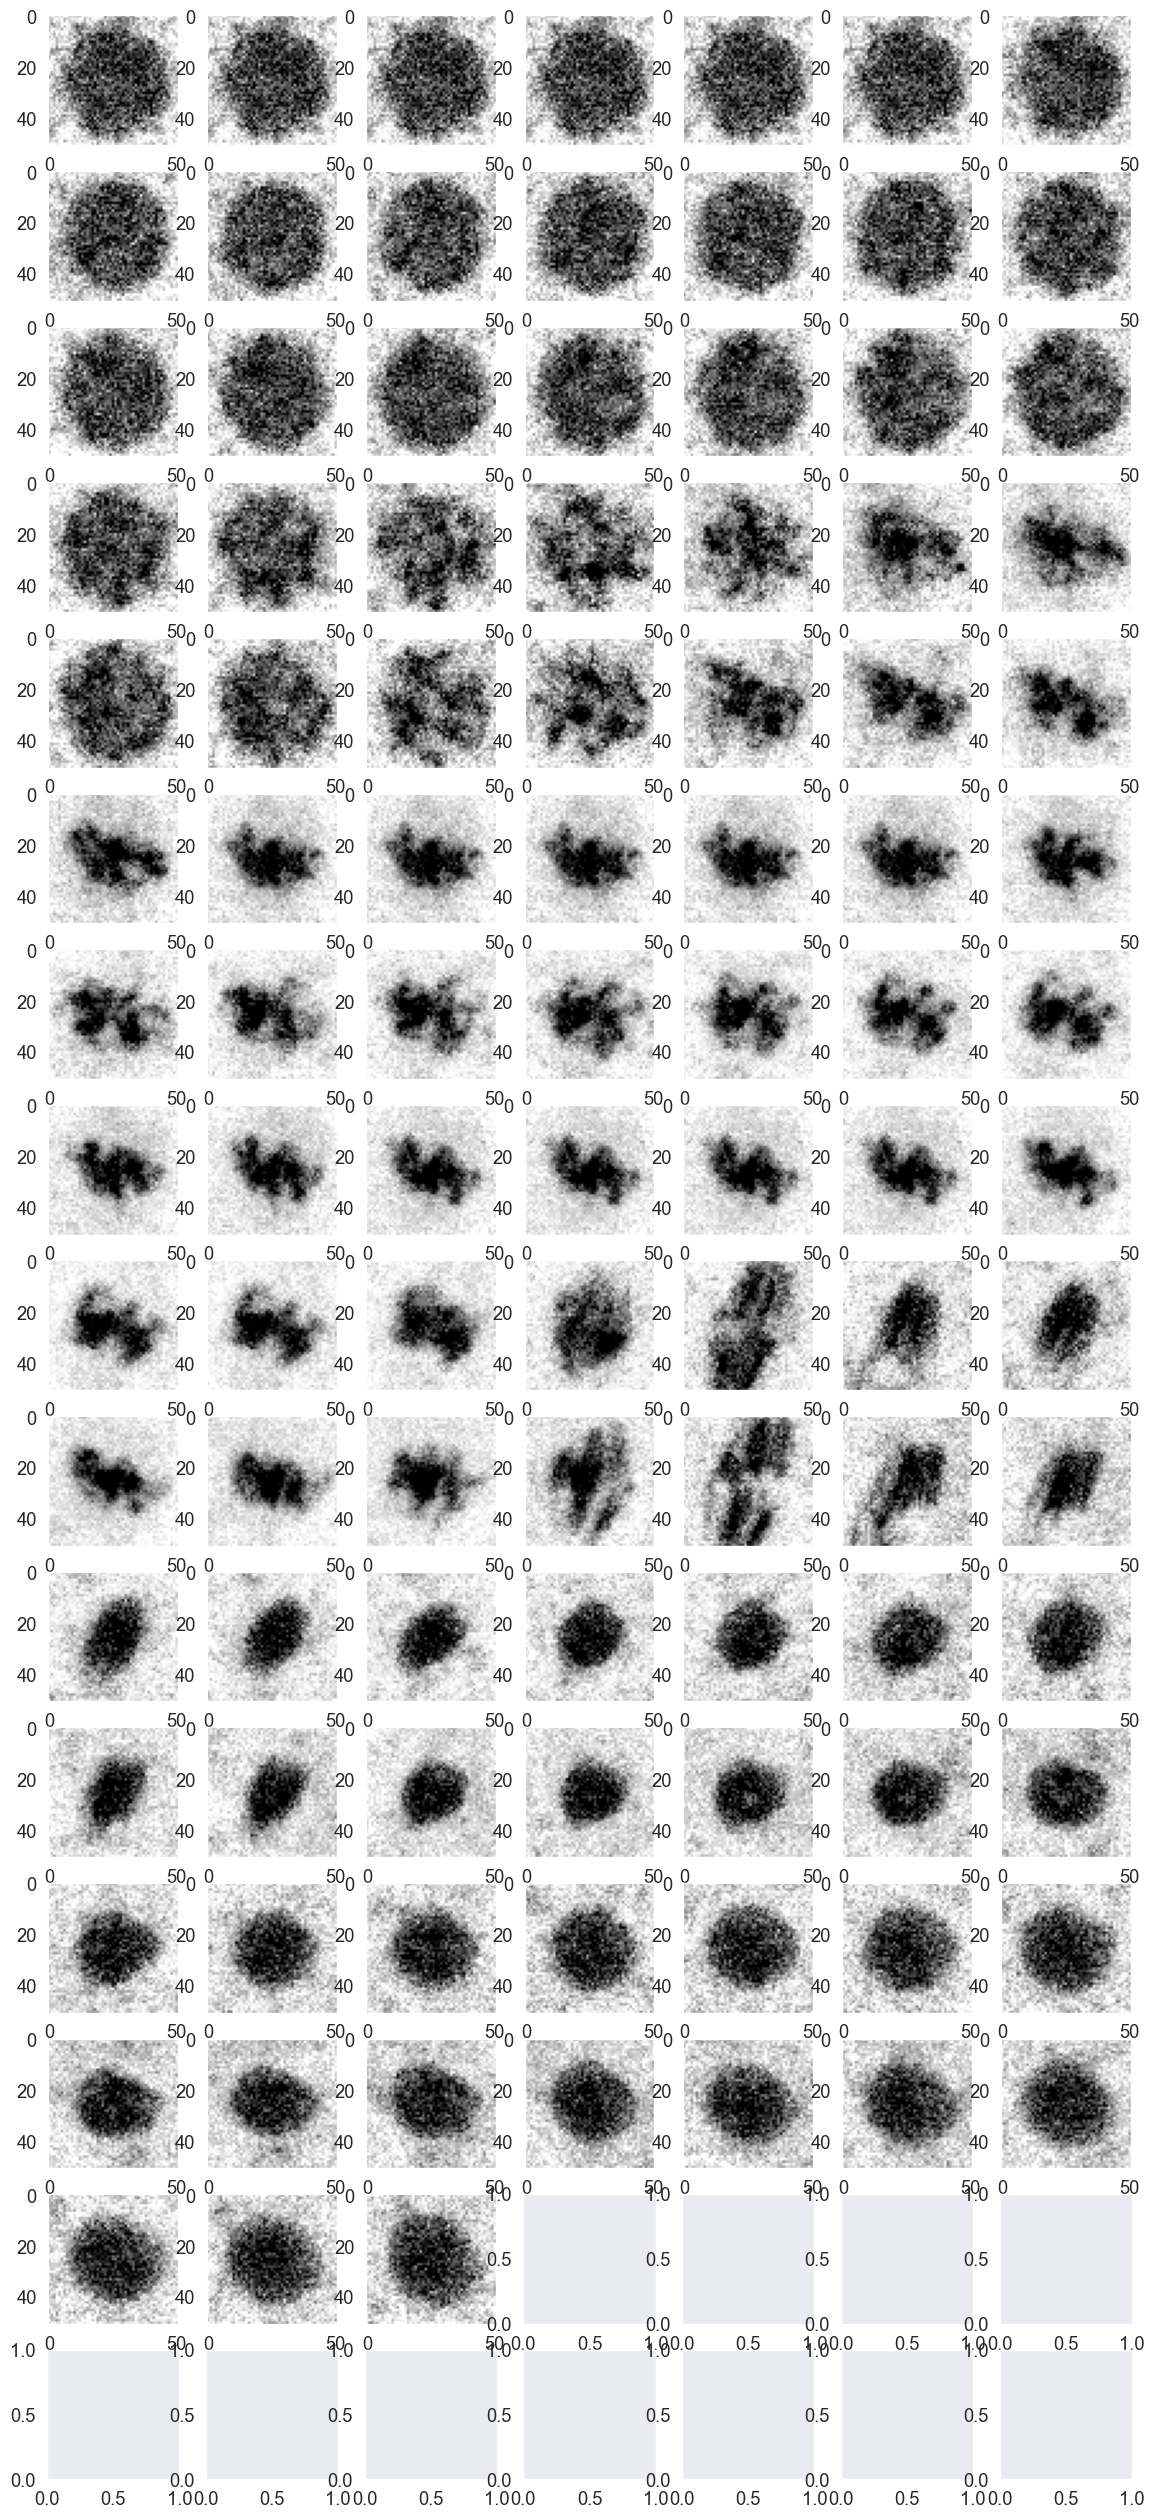

In [178]:
def plot_aligned_path(path, img1, img2):
    n = len(path)
    nrows = int(np.ceil(np.sqrt(n)))
    ncols = int(np.ceil(n/nrows))
    
    fig, axes = plt.subplots(nrows*2, ncols, figsize = (ncols*2, nrows*4))
    
    for i, (ax, j) in enumerate(zip(axes.flatten(), range(len(path)*2))):
        parity = (i // ncols) % 2 == 0
        imgsource = img1 if parity else img2
        pathidx = i - (((i // ncols) + 1) // 2) * ncols 
        ax.imshow(imgsource[path[pathidx][parity]].reshape(h, h), cmap="gray_r")

plot_aligned_path(best_path, imgs1, imgs2)
plt.savefig(savepath / "dtw_aligned.png", dpi=1200)

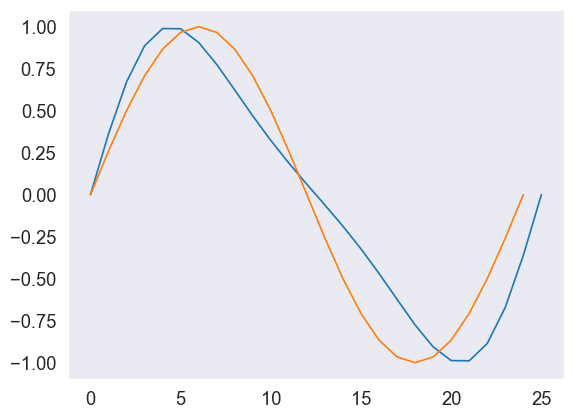

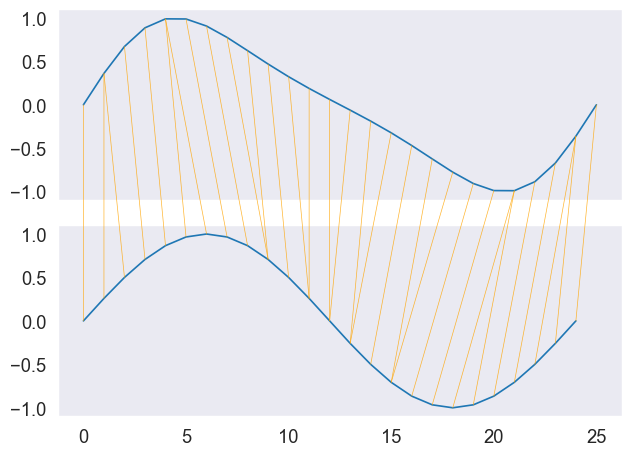

In [187]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import numpy as np

pt = np.linspace(0, 2*np.pi, 25)
s1_delta = 1 + np.cos(pt)*0.5
s1_integ = np.cumsum(s1_delta) / np.sum(s1_delta)
s1_integ = s1_integ * 2* np.pi
s1_integ = np.concatenate([[0], s1_integ])
s1 = np.sin(s1_integ)
s2 = np.sin(pt)

plt.plot(s1)
plt.plot(s2)
plt.show()

path = dtw.warping_path(s1, s2)
dtwvis.plot_warping(s1, s2, path)
plt.savefig(savepath / "dtw_demo.png", dpi=1200)

In [ ]:
all_fourier_sep = np.array([list(np.real(arr)) + list(np.imag(arr)) for arr in all_fourier])
all_fourier_sep.shape

In [85]:
latent_class = umap.UMAP()
latent_embeddings = latent_class.fit_transform(np.array(all_fourier_sep)/2**5)
nucleus_df["lat_embedding_0"] = latent_embeddings[:, 0]
nucleus_df["lat_embedding_1"] = latent_embeddings[:, 1]

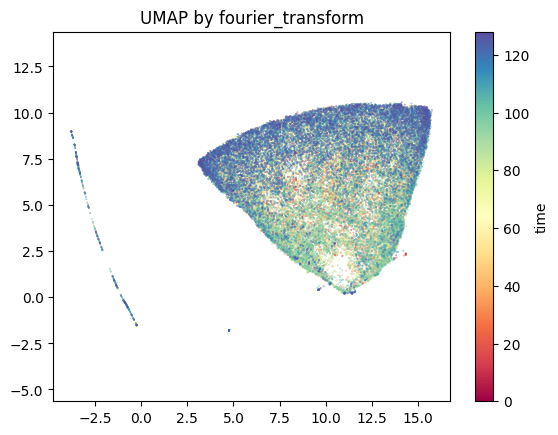

In [86]:
plt.scatter(latent_embeddings[:, 0], latent_embeddings[:, 1], c=nucleus_df["t"], cmap='Spectral', s=.05)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(label="time")
plt.title('UMAP by fourier_transform')

plt.savefig(str(Path.cwd().parent / "nucleitracking/results/plots/unet_umap_ae_withtime.png"), dpi=1200)

plt.show()

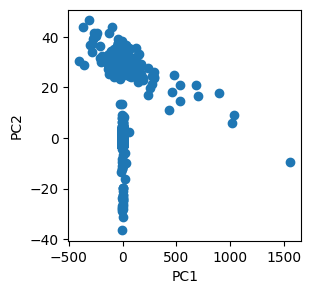

In [93]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
trans = pca.fit_transform(all_fourier_sep[all_fourier_sep.sum(axis=1) < 1000])

df_trans = pd.DataFrame(trans)
df_trans.columns = ['PC1', 'PC2', 'PC3', "PC4"]

fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.scatter(df_trans.PC1, df_trans.PC2)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

C:\Users\Harrison\.conda\envs\linajea\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


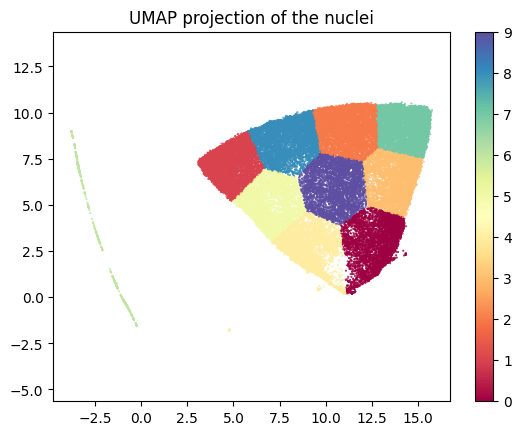

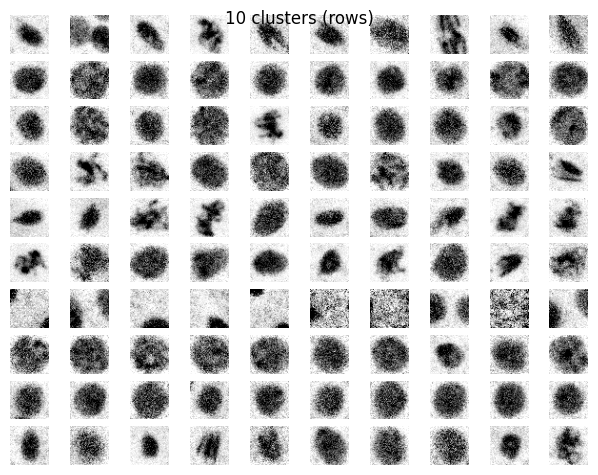

In [87]:
kmeans_labels = cluster.KMeans(n_clusters=10).fit_predict(latent_embeddings)

nucleus_df["kmeans_cluster"] = kmeans_labels

plt.scatter(latent_embeddings[:, 0], latent_embeddings[:, 1], c=kmeans_labels, cmap='Spectral', s=0.2)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar()
plt.title('UMAP projection of the nuclei')
plt.show()

fig, ax_array = plt.subplots(10, 10)
for i, ax_row in enumerate(ax_array):
    cluster_imgs = list(nucleus_df[nucleus_df["kmeans_cluster"] == i].sample(10)["img"])
    for j, ax in enumerate(ax_row):
        img = cluster_imgs[j].reshape(h, h)
        ax.imshow(img, cmap="gray_r")

plt.setp(ax_array.flatten(), xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.5, w_pad=0.01)
plt.suptitle("10 clusters (rows)")
plt.show()

In [89]:
plt.plot((np.abs(all_fourier_sep.median(axis=0))))

AttributeError: 'numpy.ndarray' object has no attribute 'median'

In [68]:
def plot_contours(contour, inverse_fourier):
    # Plot the results
    plt.figure()
    plt.plot(contour[:, 0], contour[:, 1], "k")
    plt.plot(inverse_fourier[:, 0], inverse_fourier[:, 1], "r")
    plt.axis("equal")
    plt.show()

k = 5

idx = np.random.randint(0, np.array(all_fourier).shape[0], k)
for i in idx:
    print(i)
    plot_contours(np.array(all_fourier[i, :]), np.array(all_inv_fourier)[i, :])

12190


TypeError: list indices must be integers or slices, not tuple

In [69]:
print(np.median(all_fourier, axis=0))

[ 5.94192863e+02 +0.j          1.83215046e+01+14.86451449j
  2.07065633e+01 +3.81197355j -6.78763042e-02 +6.72403621j
  6.35338218e-01 +3.56416779j -4.00490921e-01 -1.96353946j
 -2.60740384e-01 +1.88698756j -2.98994139e-01 -0.85853466j
 -2.00017294e-01 -1.32802411j -1.90635262e-01 +0.75133575j
 -1.29900363e-01 -0.84962112j -1.16532498e-01 -0.1789205j
 -1.07683365e-01 +0.98717038j -1.04020524e-01 -0.31511148j
 -9.72179177e-02 -1.24839527j -8.96514869e-02 -0.46201434j
 -9.28199629e-02 +0.j         -8.96514869e-02 +0.46201434j
 -9.72179177e-02 +1.24839527j -1.04020524e-01 +0.31511148j
 -1.07683365e-01 -0.98717038j -1.16532498e-01 +0.1789205j
 -1.29900363e-01 +0.84962112j -1.90635262e-01 -0.75133575j
 -2.00017294e-01 +1.32802411j -2.98994139e-01 +0.85853466j
 -2.60740384e-01 -1.88698756j -4.00490921e-01 +1.96353946j
  6.35338218e-01 -3.56416779j -6.78763042e-02 -6.72403621j
  2.07065633e+01 -3.81197355j  1.83215046e+01-14.86451449j]
